In [3]:
import os
import sys
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')
pplt.rc.update({'reso':'xx-hi','figure.dpi':100})

In [4]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'   

In [5]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()

results = {}
for model in MODELS:
    name,description = model['name'],model['description']
    filename = f'{name}_{SPLIT}_predictions.nc'
    filepath = os.path.join(PREDSDIR,filename)
    if os.path.exists(filepath):
        with xr.open_dataset(filepath,engine='h5netcdf') as ds:
            predpr = ds.pr.load()
        ytrue,ypred = xr.align(truepr,predpr,join='inner')
        results[name] = dict(description=description,ytrue=ytrue,ypred=ypred)
print(f'Found {len(results)} completed models for `{SPLIT}`')

nrows = 2
ncols = 4

Found 6 completed models for `valid`


In [7]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=0.5):
    dims = list(ytrue.dims) if dims is None else dims
    if landfrac is not None:
        r2values = []
        for mask in [landfrac>=landthresh,landfrac<landthresh]:
            ssres = ((ytrue.where(mask)-ypred.where(mask))**2).sum(dim=dims,skipna=True)
            sstot = ((ytrue.where(mask)-ytrue.where(mask).mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
            r2values.append(1-ssres/sstot)
        return tuple(r2values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

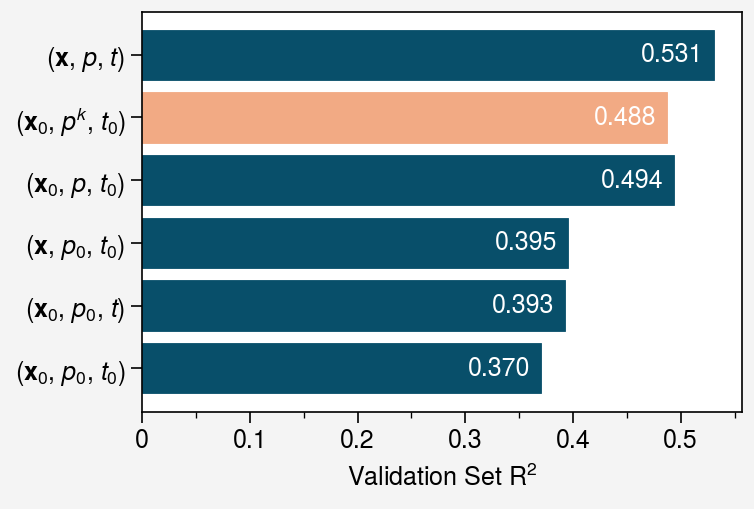

In [12]:
labels, r2s, colors = [], [], []

other = [(runname, result) for runname, result in results.items()]

def sort_key(item):
    runname, _ = item
    if runname == 'baseline_only_local':
        return (0, runname)
    if runname == 'baseline_only_temporal':
        return (1, runname)
    if runname == 'baseline_only_horizontal':
        return (2, runname)
    if runname == 'baseline_only_vertical':
        return (3, runname)
    if runname == 'nonparametric_vertical':
        return (4, runname)
         
    if runname == 'baseline_full':
        return (5, runname)
    else:
        None

other = sorted(other, key=sort_key)
for runname, result in other:
    description = result['description']
    ytrue, ypred = result['ytrue'], result['ypred']
    r2 = get_r2(ytrue, ypred, dims=None)
    labels.append(description)
    r2s.append(r2)
    colors.append('#f2aa84' if runname == 'nonparametric_vertical' else '#084f6a')

fig, ax = pplt.subplots(nrows=1, ncols=1, refwidth=3, refheight=2)
ax.format(xlabel='Validation Set R$^2$', xticks=0.1, xminorticks=0.05, ylabel='', grid=False)
bars = ax.barh(labels, r2s, color=colors, capsize=3)
for bar, r2 in zip(bars, r2s):
    ax.text(bar.get_width()-0.01, bar.get_y()+bar.get_height()/2, f'{r2:.3f}',
            va='center', ha='right', color='white')
pplt.show()

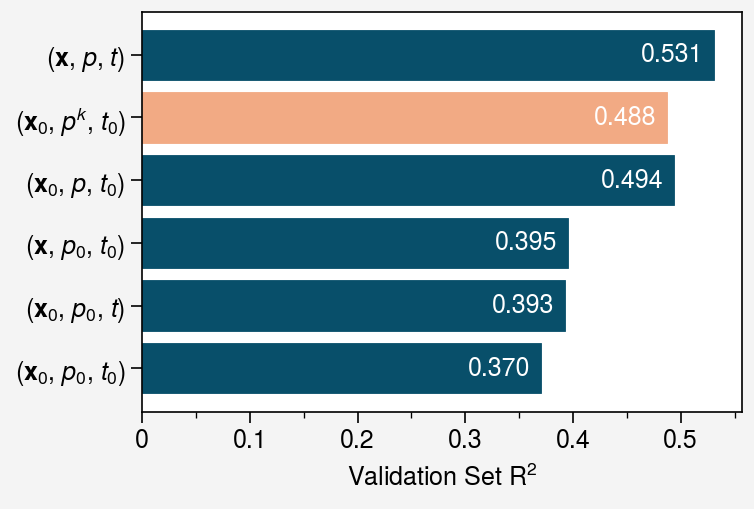

In [13]:
# Pre-compute all bars
bars_data = []
for runname, result in results.items():
    description = result['description']
    ytrue, ypred = result['ytrue'], result['ypred']
    r2 = get_r2(ytrue, ypred, dims=None)
    color = '#f2aa84' if runname == 'nonparametric_vertical' else '#084f6a'
    bars_data.append((runname, description, r2, color))

# Sort bars
def sort_key(item):
    runname, _, _, _ = item
    order = {
        'baseline_only_local': 0,
        'baseline_only_temporal': 1,
        'baseline_only_horizontal': 2,
        'baseline_only_vertical': 3,
        'nonparametric_vertical': 4,
        'baseline_full': 5
    }
    return (order.get(runname, 999), runname)

bars_data = sorted(bars_data, key=sort_key)

# Unpack for plotting
labels = [item[1] for item in bars_data]
r2s = [item[2] for item in bars_data]
colors = [item[3] for item in bars_data]

# Plot
fig, ax = pplt.subplots(nrows=1, ncols=1, refwidth=3, refheight=2)
ax.format(xlabel='Validation Set R$^2$', xticks=0.1, xminorticks=0.05, ylabel='', grid=False)
bars = ax.barh(labels, r2s, color=colors, capsize=3)
for bar, r2 in zip(bars, r2s):
    ax.text(bar.get_width()-0.01, bar.get_y()+bar.get_height()/2, f'{r2:.3f}',
            va='center', ha='right', color='white')
pplt.show()


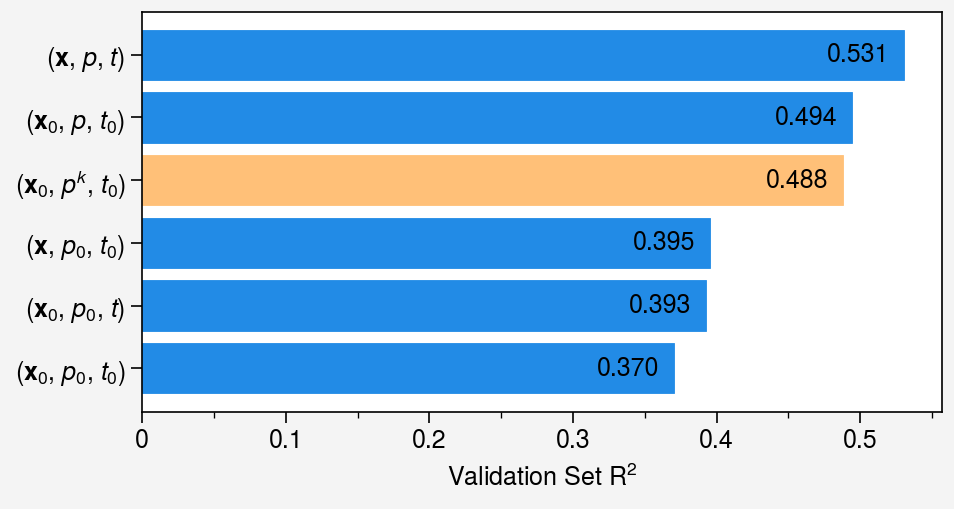

In [19]:
barsdata = []
for runname,result in results.items():
    description  = result['description']
    ytrue,ypred = result['ytrue'],result['ypred']
    r2 = get_r2(ytrue,ypred,dims=None)
    color = 'orange3' if 'nonparametric' in runname else 'blue6'
    barsdata.append((runname,description,r2,color))
barsdata = sorted(barsdata,key=lambda x:x[2])

labels = [item[1] for item in barsdata]
r2s    = [item[2] for item in barsdata]
colors = [item[3] for item in barsdata]

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=2)
ax.format(xlabel='Validation Set R$^2$',xticks=0.1,xminorticks=0.05,ylabel='',grid=False)
bars = ax.barh(labels,r2s,color=colors,capsize=3)
for bar,r2 in zip(bars,r2s):
    ax.text(bar.get_width()-0.01,bar.get_y()+bar.get_height()/2,f'{r2:.3f}',va='center',ha='right',)
pplt.show()